# <b>Data Exploration </b> *✲ﾟ*｡✧٩(･ิᴗ･ิ๑)۶*✲ﾟ*｡✧

## Intro

<b>What data?</b> <br> We are working with the immobilized whole brain imaging data from Kerem and Rebecca. They only include control data, meaning that the worm is a wild type and has no modification apart from the GFP. The data, which were originally stored in separate wbstruct.mat files, have been converted to a dictionary of pandas dataframes (stored in a pickle file for easier handling but also into separate h5 files and csv files for easier sharing). 

<b>What kind of exploration?</b> <br> 
We want to understand the individual datasets and get a feeling of what problems we might face, whether we need to do some processing before we start with the analysis. For now, we especially want to know and make following decisions:
- Are all neurons in each dataset IDed? (If no, remove)
- How many neurons are IDed in each dataset?
- How many times is each neuron IDed in total? (If too few, remove or impute)
- Are neurons with few total number of IDs unique? (If no, impute. Else remove)
- How to deal with missing IDs of nonunique neurons? Which imputation method? 

In [2]:
import sys
import textwrap
import wbstruct_converter.utils.wbstruct_dicts_to_dataframes as wbstruct_dataframes
from wbstruct_converter import utils
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
import helper_functions

#for wrapping outputs
wrapper = textwrap.TextWrapper(width=50)

#for loading the pkl objects we need to import the module
sys.modules['utils'] = utils

sys.path.append('C:\\Users\\LAK\\Documents\\lianaforks\\wbfm')
import wbfm.utils.general.postprocessing.utils_imputation as utils_imputation
import wbfm.utils.visualization.plot_traces as plot_traces

<module 'helper_functions' from 'c:\\Users\\LAK\\Documents\\plots\\neumand\\data\\helper_functions.py'>

## Some Quantifications 


We will first look at the number of IDs per neuron in all datasets and the number of IDs per dataset.

In [3]:
# load dataframe dictionaries
dataframes=wbstruct_dataframes.loading_pkl('dataframes_rebecca.pkl')
dataframes_kerem=wbstruct_dataframes.loading_pkl('dataframes_kerem.pkl')

# merging rebecas and kerems dataframe dictionaries
dataframes.update(dataframes_kerem)

all_IDed_neurons, IDs_per_set = helper_functions.count_IDs(dataframes)

print("Count of IDed neurons per set: ",IDs_per_set,"\n")
print("Count of IDed neurons per set: ",all_IDed_neurons,"\n")


Count of IDed neurons per set:  defaultdict(None, {'20200629_w1': 59, '20200708_w3': 64, '20200714_w3': 62, '20200716_w2': 61, '20200724_w3': 41, '20200724_w4': 64, '20200826_w3': 54, '20200826_w6': 65, '20200922_w1': 57, '20200930_w4': 66, '20201007_w4': 66, '20210112_w3': 68, '20210113_w1': 71, '20210126_w2': 60, '20210203_w2': 72, '20210323_w6': 70, '20210324_w5': 67, '20210330_w5': 67, '20210414_w7': 67, 'Dataset1_20190125_ZIM1428_Ctrl_w2': 64, 'Dataset2_20180207_TKU862_Ctrl_w6': 58, 'Dataset3_20180112_TKU761_Ctrl_w1': 57, 'Dataset4_20170927_ZIM1428_Ctrl_w7': 49, 'Dataset5_20181217_ZIM1428_w2': 59, 'Dataset6_20190315_ZIM1428_1xHis_w1': 41}) 

Count of IDed neurons per set:  Counter({'AVAR': 25, 'AVAL': 25, 'ASKL': 25, 'AVER': 25, 'ALA': 25, 'RIMR': 25, 'AVFL': 25, 'SMDVL': 24, 'RID': 24, 'AVEL': 24, 'AIBR': 24, 'AVBR': 24, 'AIBL': 24, 'OLQVL': 23, 'RMED': 23, 'SMDVR': 23, 'AVFR': 23, 'VB01': 23, 'PVCL': 23, 'DVA': 23, 'AVBL': 23, 'OLQVR': 22, 'ASKR': 22, 'SMDDL': 22, 'SMDDR': 22, '

#### Let's visualize this information with a cute matplotlib plot 

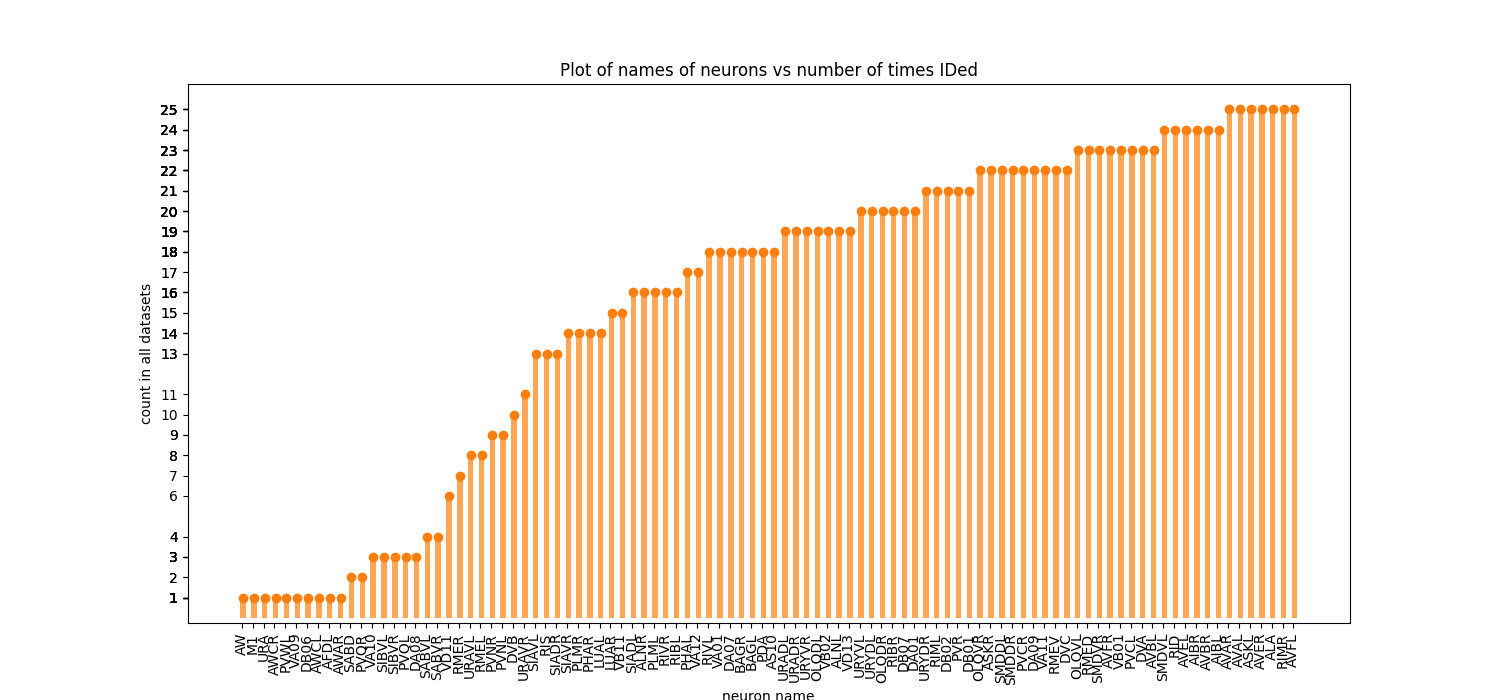

In [4]:
# plot the number of IDed neurons per set
fig, ax = helper_functions.visualize_IDs(all_IDed_neurons, title="Plot of names of neurons vs number of times IDed",yaxis="count in all datasets",display_all_values=True)
plt.show()


Most neurons are ID'ed more than 16 times while there are some neurons that are IDed less than 10 times. Considering we have 25 datasets, having to impute more IDs that exist in all datasets might not be a good idea. We could set a threshold to only impute IDs that are present in at least 10 datasets. This would reduce the number of IDs to impute to 25.
But before we make the cut we want to know how unique each neuron is. Let's say neuron RMER, which isn't IDed very much, is not very unique in the entirety of the datasets, meaning we could impute the recording of the neuron in all the datasets where it's missing. But if RMER is very unique, the imputation might lead to a completely wrong result.

## "Uniqueness" of neurons

So we want to know how unique each neuron is across all datasets. 
We will run a Least Square Regression model d(=number of datasets)*n(=number of neurons) times where in each round y will be a single neuron and X will be all neurons but y. The aim is to see how well a neuron can be explained by all the other neurons. We can get a rough understanding of this by looking at the R<sup>2</sup> value of each LS model. 

<b>R-Squared R<sup>2</sup></b>
<br>
The R<sup>2</sup> measures the proportion of the neurons variance or spread explained by all the other neurons. R<sup>2</sup> ranges from 0 to 1 where 1 indicates that all the variance is explained by the other neurons and 0 indicates that none of the variance is explained by the other neurons. Now, if in our case the R<sup>2</sup>-value is high, we can say that the neuron is not very unique and we can impute the missing IDs. If the R<sup>2</sup>-value is low, we can say that the neuron is very unique and we should not impute the missing IDs. We will look at the average R<sup>2</sup> across all datasets.

In [5]:
avg_r2, predictions, raw_data = helper_functions.get_R2_predictions(dataframes, all_IDed_neurons)

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Average R2 values'}, xlabel='neuron name', ylabel='R2'>)

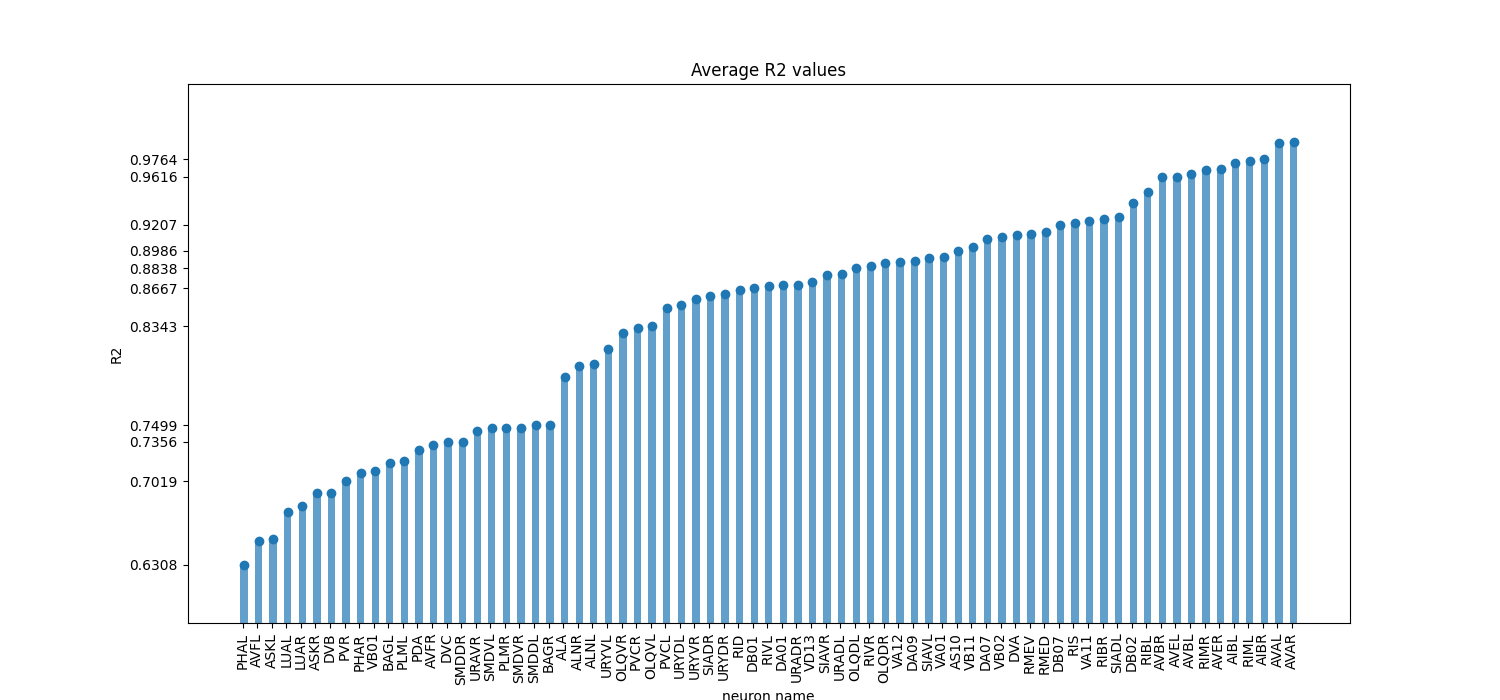

In [6]:
helper_functions.visualize_IDs(avg_r2, title="Average R2 values", yaxis="R2", coloring="tab:blue")

## Plotting modelled neuron activity against true activity

In [20]:
%%capture
%matplotlib widget
# we don't want to output all plots, just save them

modelled_activity_patterns = defaultdict()
delta_path="C:\\Users\\LAK\\Documents\\delta_plots\\"
model_path="C:\\Users\\LAK\\Documents\\modelled_plots\\"

plot_kwargs = {'alpha': 0.7}


for neuron, df in predictions.items():
    raw_neuron = list(raw_data[neuron].values())
    modelled_neuron = list(df.values())
    diff = [raw_neuron[i]-modelled_neuron[i] for i in range(len(raw_neuron))]
    
    modelled_activity_patterns[neuron] = pd.DataFrame(modelled_neuron).T

    # Calculate the number of rows and columns for subplots
    num_rows, num_cols = helper_functions.get_num_rows_columns(modelled_activity_patterns[neuron])
    
    figsample, ax = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    # create delta figures
    fig_delta, ax = plot_traces.make_grid_plot_from_dataframe(pd.DataFrame(diff).T, fig=figsample)
    fig_delta.savefig(delta_path+neuron+".png")
    
    # clear figure
    plt.cla()

    figsample, ax = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    fig, ax = plot_traces.make_grid_plot_from_dataframe(
        modelled_activity_patterns[neuron], fig=figsample)

    fig, ax = plot_traces.make_grid_plot_from_dataframe(pd.DataFrame(raw_neuron).T, fig=fig, twinx_when_reusing_figure=True,**plot_kwargs)

    # save all plots in a folder
    fig.savefig(model_path+neuron+".png")


## ID imputation with PPCA

In [12]:
stacked_dataframe = pd.concat([df for df in dataframes.values()], ignore_index=True)

threshold = 10

# we stack all neurons that have less than 10 IDs
stacked_dataframe = stacked_dataframe.drop(columns=[neuron for neuron in stacked_dataframe.columns if all_IDed_neurons[neuron] < threshold])

# the data is imputed with PPCA
imputed_dataframe = utils_imputation.impute_missing_values_in_dataframe(stacked_dataframe)
imputed_dataframe

c:\Users\ZimAdmin\AppData\Local\Programs\Python\Python310\lib\site-packages\ppca\_ppca.py:82: RuntimeWarning: divide by zero encountered in log
  det = np.log(np.linalg.det(Sx))


,URADL,URADR,URYVR,URYVL,URYDR,URYDL,OLQDL,OLQVL,URAVR,RMED,...,DB01,DA01,DVB,DVC,PDA,AS10,VB11,RIVR,RIBL,SIADR
0,0.362247,0.268870,0.207330,0.304520,0.261854,0.264241,0.718043,0.424508,0.180676,0.262258,...,0.319069,0.755575,0.456690,0.987904,0.133019,0.391722,0.266158,0.360523,0.374883,0.311684
1,0.334562,0.285975,0.232692,0.272279,0.240964,0.285008,0.698511,0.396316,0.195020,0.220053,...,0.306853,0.739465,0.430942,0.941415,0.116527,0.358522,0.259247,0.347442,0.361756,0.324923
2,0.337621,0.274959,0.256516,0.311110,0.266116,0.299377,0.712704,0.426034,0.208328,0.226081,...,0.307639,0.734732,0.457904,0.976558,0.126411,0.384698,0.243568,0.365898,0.390277,0.303576
3,0.297204,0.242873,0.176090,0.256018,0.224283,0.239688,0.644670,0.389113,0.171029,0.194837,...,0.263704,0.680765,0.393906,0.891187,0.133401,0.356760,0.208137,0.311962,0.313428,0.275294
4,0.324939,0.239417,0.182565,0.268602,0.223360,0.254398,0.639860,0.389503,0.152927,0.193422,...,0.275112,0.684683,0.376963,0.885669,0.129774,0.354794,0.194837,0.314351,0.301570,0.257563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88539,0.077261,0.074462,0.105622,0.091258,0.070679,0.103842,0.145707,0.039689,0.062161,0.809000,...,0.245616,0.406375,0.225249,0.673241,0.219289,0.316467,0.179641,0.080279,0.035517,0.012778
88540,0.059242,0.068976,0.099807,0.084720,0.026907,0.063788,0.131263,0.040000,0.064466,0.788587,...,0.242059,0.424368,0.224449,0.649669,0.212255,0.304955,0.187194,0.064952,0.048814,0.030170
88541,0.081071,0.079497,0.101743,0.091825,0.073201,0.091530,0.141605,0.053817,0.063110,0.790447,...,0.233480,0.413030,0.222574,0.665003,0.221170,0.308007,0.166801,0.057847,0.038570,0.016279
88542,0.078187,0.076321,0.104644,0.093966,0.066290,0.097600,0.145602,0.063853,0.062576,0.773798,...,0.223214,0.411529,0.216659,0.655204,0.216721,0.311883,0.176273,0.070672,0.051676,0.007106


In [14]:
%%capture 
#we don't want to output all plots, just save them


# we will save all dataframe keys and their lengths in a dictionary for the unstacking part
length_dict = defaultdict()
for key, value in dataframes.items():
    length_dict[key] = len(value)

unstacked_dataframes = defaultdict()
start_index = 0
count = 0

saving_path="C:\\Users\\LAK\\Documents\\imputed_plots\\"

# we will unstack the dataframe and plot the traces for each dataset
for obs_count in list(length_dict.values()):


    # we take the number of observations from the length dictionary and add it to the start index
    end_index = start_index + obs_count
    df_imputed = imputed_dataframe.iloc[start_index:end_index]
    df_unimputed = stacked_dataframe.iloc[start_index:end_index]

    # 2 dataframe grid plots, imputed in blue (first argument, such that it is in the back) and unimputed in orange (second argument, on top)
    fig = plot_traces.make_grid_plot_from_two_dataframes(df_imputed, df_unimputed)
    #fig, ax = plot_traces.make_grid_plot_from_dataframe(df_imputed)

    # save all plots in a folder
    pathname = saving_path + list(length_dict.keys())[count] + ".png"
    fig.savefig(pathname)
    plt.close(fig)
    start_index = end_index
    count += 1
